# Model is Overfitting

## Key Issues Observed:

* Training loss is decreasing (from 138.5 to 2.1) but validation loss is increasing (from 4.6 to 14.7) - this is a clear sign of overfitting
* Very low accuracy values (around 0.0002 for training and 0 for validation)
* Increasing gap between training and validation RMSE

## Suggestive Measures:

1. **Regularization Techniques:**
* Add dropout layers (start with 0.2-0.3)
* Add L1/L2 regularization to your layers
* Try batch normalization

2. **Data Preprocessing:**
* Normalize/standardize your input data
* Check for and handle outliers
* Ensure proper train/validation split methodology for time series (maintain temporal order)
* Consider differencing or detrending if your data has strong trends

3. **Model Architecture:**
* Reduce model complexity if you have a deep network
* If using LSTM/GRU, adjust the number of units
* Try simpler architectures first (fewer layers)
* Consider adding skip connections

4. **Training Process:**
* Implement early stopping (your model starts overfitting after epoch 4)
* Reduce learning rate (try using learning rate scheduler)
* Experiment with different batch sizes
* Use K-fold cross-validation adapted for time series

5. **Feature Engineering:**
* Add relevant lag features
* Include domain-specific features
* Consider adding cyclical encodings for seasonal data
* Create rolling statistics features

In [1]:
import os
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1.0 Data Ingestion

In [2]:
df = pd.read_csv('../artifacts/dataset/01-hourly_historical_analyzed_data.csv')
df = df.drop(columns=['hour', 'day', 'month', 'year'])

df1 = df.copy()
df1.index = pd.to_datetime(df1['time'], format='%Y-%m-%d %H:%M:%S')
df1

,time,temperature_2m,relative_humidity_2m,dew_point_2m,rain,cloud_cover_low,cloud_cover_mid,et0_fao_evapotranspiration,vapour_pressure_deficit,wind_speed_10m,wind_speed_100m,wind_gusts_10m
time,,,,,,,,,,,,
2000-01-01 00:00:00,2000-01-01 00:00:00,4.0,96,3.3,0.0,0,0,0.00,0.04,3.8,3.6,11.5
2000-01-01 01:00:00,2000-01-01 01:00:00,4.1,95,3.3,0.0,0,1,0.00,0.04,4.1,4.4,11.9
2000-01-01 02:00:00,2000-01-01 02:00:00,4.0,95,3.2,0.0,0,1,0.01,0.04,3.8,4.5,11.9
2000-01-01 03:00:00,2000-01-01 03:00:00,6.5,92,5.3,0.0,0,3,0.02,0.07,4.3,4.0,13.0
2000-01-01 04:00:00,2000-01-01 04:00:00,12.9,75,8.6,0.0,0,0,0.13,0.37,2.0,2.5,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-01 19:00:00,2025-01-01 19:00:00,9.8,77,5.8,0.0,0,0,0.00,0.28,3.0,5.8,6.1
2025-01-01 20:00:00,2025-01-01 20:00:00,10.6,67,4.7,0.0,0,0,0.00,0.43,2.8,6.2,6.1
2025-01-01 21:00:00,2025-01-01 21:00:00,11.1,59,3.3,0.0,0,0,0.00,0.54,3.5,5.8,6.1


In [3]:
rain = df1['rain']
rain_df = pd.DataFrame({'Rain': rain})

rain_df[rain_df['Rain'] != 0]['Rain']

time
2000-01-09 04:00:00    0.1
2000-01-11 02:00:00    0.2
2000-01-11 03:00:00    0.3
2000-01-12 04:00:00    0.2
2000-01-12 05:00:00    0.6
                      ... 
2024-12-28 04:00:00    1.1
2024-12-28 05:00:00    1.3
2024-12-28 06:00:00    0.3
2024-12-28 10:00:00    0.1
2024-12-28 11:00:00    0.1
Name: Rain, Length: 35978, dtype: float64

# 2.0 Data Pre-processing

## 2.1 Convert: Time stamp -> Cyclic Signals

### Summary:

The cyclical component of a time series is a long-term variation in data that repeats in a systematic way over time. It's characterized by rises and falls that are not fixed in period, and are usually at least two years in duration. The cyclical component is often represented by a wave-shaped curve that shows alternating periods of expansion and contraction. 

Here are some examples of cyclical components in time series:
* **Canadian lynx data:** This data shows population cycles of about 10 years. 
* **Stock market:** The stock market cycles between periods of high and low values, but there is no set amount of time between those fluctuations. 
* **Home prices:** There is a cyclical effect due to the market, but there is also a seasonal effect because most people would rather move in the summer.

Cyclical components are different from seasonal components, which are variations that occur periodically in the data and are usually associated with changes in seasons, days of the week, or hours of the day.

#### *Research/References:*

1. [Components of Time Series Analysis](https://www.toppr.com/guides/business-mathematics-and-statistics/time-series-analysis/components-of-time-series/#:~:text=The%20variations%20in%20a%20time,called%20the%20'Business%20Cycle'.)
2. [Cyclic and seasonal time series by Rob J Hyndman](https://robjhyndman.com/hyndsight/cyclicts/)
3. [Time Series Analysis by Arief Wicaksono](https://medium.com/@ariefwcks303/time-series-analysis-bb61d1d1b3d5)

### How to Convert:

To convert a timestamp into a time series cyclic component, you need to extract cyclical features from the timestamp by calculating trigonometric functions like sine and cosine based on the relevant time unit (e.g., hour, day, month) within the cycle, effectively mapping the time point onto a circular representation where each cycle is represented by a full rotation on the unit circle; this is often done using the "sinusoidal encoding" method. 

#### Steps:

1. **Convert timestamp to datetime object:** Use your programming language's datetime functions to convert the timestamp into a datetime object, allowing you to easily extract components like hour, day, month, etc.
2. **Calculate cyclical features:**
   * **Extract relevant time unit:** Depending on your analysis, extract the specific time unit that represents the cycle (e.g., hour for daily cycles, month for yearly cycles). 
   * **Normalize the unit:** Divide the extracted time unit by the maximum value within the cycle (e.g., divide hour by 23 to get a value between 0 and 1). 
   * **Apply sine and cosine functions:** Calculate the sine and cosine of the normalized time unit. These values will represent the cyclical component of your timestamp.

#### *Research/References:*

1. [Components of Time Series](https://ming-zhao.github.io/Business-Analytics/html/docs/time_series/components.html#:~:text=A%20seasonal%20behavior%20is%20very,seasonal%20(or%20cyclical)%20effects.)
2. [Feature engineering of timestamp for time series analysis](https://datascience.stackexchange.com/questions/107215/feature-engineering-of-timestamp-for-time-series-analysis)
3. [SQL: How can I generate a time series from timestamp data and calculate cumulative sums across different event types?](https://stackoverflow.com/questions/76295454/sql-how-can-i-generate-a-time-series-from-timestamp-data-and-calculate-cumulati)
4. [Time Series Analysis Through Vectorization](https://www.pinecone.io/learn/time-series-vectors/)
5. [Cyclical features in time series forecasting](https://skforecast.org/0.9.0/faq/cyclical-features-time-series#:~:text=Basis%20functions:%20Basis%20functions%20are,a%20piecewise%20combination%20of%20polynomials.)
6. [Cyclical Encoding: An Alternative to One-Hot Encoding for Time Series Features](https://towardsdatascience.com/cyclical-encoding-an-alternative-to-one-hot-encoding-for-time-series-features-4db46248ebba#:~:text=It's%20fairly%20easy%20to%20transform,dt.)

In [4]:
# Process temporal features
rain_df['Seconds'] = rain_df.index.map(pd.Timestamp.timestamp)

day = 24 * 60 * 60
year = (365.2425) * day

# Add cyclical time features
rain_df['Day sin'] = np.sin(rain_df['Seconds'] * (2 * np.pi / day))
rain_df['Day cos'] = np.cos(rain_df['Seconds'] * (2 * np.pi / day))
rain_df['Year sin'] = np.sin(rain_df['Seconds'] * (2 * np.pi / year))
rain_df['Year cos'] = np.cos(rain_df['Seconds'] * (2 * np.pi / year))

# # Add rolling statistics
rain_df['rolling_mean_6h'] = rain_df.iloc[:, 0].rolling(window=6).mean()
rain_df['rolling_std_6h'] = rain_df.iloc[:, 0].rolling(window=6).std()
rain_df['rolling_max_6h'] = rain_df.iloc[:, 0].rolling(window=6).max()

# Add lag features
for i in [1, 3, 6, 12, 24, 36, 48]:
    rain_df[f'lag_{i}'] = rain_df.iloc[:, 0].shift(i)

rain_df

,Rain,Seconds,Day sin,Day cos,Year sin,Year cos,rolling_mean_6h,rolling_std_6h,rolling_max_6h,lag_1,lag_3,lag_6,lag_12,lag_24,lag_36,lag_48
time,,,,,,,,,,,,,,,,
2000-01-01 00:00:00,0.0,9.466848e+08,-5.461913e-12,1.000000,-0.004731,0.999989,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-01 01:00:00,0.0,9.466884e+08,2.588190e-01,0.965926,-0.004014,0.999992,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-01 02:00:00,0.0,9.466920e+08,5.000000e-01,0.866025,-0.003297,0.999995,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-01 03:00:00,0.0,9.466956e+08,7.071068e-01,0.707107,-0.002580,0.999997,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2000-01-01 04:00:00,0.0,9.466992e+08,8.660254e-01,0.500000,-0.001864,0.999998,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-01 19:00:00,0.0,1.735758e+09,-9.659258e-01,0.258819,0.025013,0.999687,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-01-01 20:00:00,0.0,1.735762e+09,-8.660254e-01,0.500000,0.025730,0.999669,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-01-01 21:00:00,0.0,1.735765e+09,-7.071068e-01,0.707107,0.026446,0.999650,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
rain_df = rain_df.bfill()
rain_df = rain_df.drop(['Seconds'], axis=1)

df2 = pd.concat([df1, rain_df], axis=1)
df2 = df2.drop(['time','rain'], axis=1)
df2.head()

,temperature_2m,relative_humidity_2m,dew_point_2m,cloud_cover_low,cloud_cover_mid,et0_fao_evapotranspiration,vapour_pressure_deficit,wind_speed_10m,wind_speed_100m,wind_gusts_10m,...,rolling_mean_6h,rolling_std_6h,rolling_max_6h,lag_1,lag_3,lag_6,lag_12,lag_24,lag_36,lag_48
time,,,,,,,,,,,,,,,,,,,,,
2000-01-01 00:00:00,4.0,96,3.3,0,0,0.00,0.04,3.8,3.6,11.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-01-01 01:00:00,4.1,95,3.3,0,1,0.00,0.04,4.1,4.4,11.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-01-01 02:00:00,4.0,95,3.2,0,1,0.01,0.04,3.8,4.5,11.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-01-01 03:00:00,6.5,92,5.3,0,3,0.02,0.07,4.3,4.0,13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2000-01-01 04:00:00,12.9,75,8.6,0,0,0.13,0.37,2.0,2.5,13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 2.2 Create: Lagged Features

### Summary:

A lag feature in a time series is a feature that contains the value of a time series at a previous time point. The user sets the lag, or the number of periods in the past, for the feature. For example, a lag of 1 means the feature contains the previous time point value, while a lag of 3 means the feature contains the value three time points before.

Lag features can be created by shifting the original data by one or more time steps. For example, if you have a daily time series of sales, you can create a lagged feature that shows the sales of the previous day, the same day last week, or the same day last year.

In Python, you can create lag features using the pandas method shift. For example, X[my_variable].shift(freq=”1H”, axis=0) creates a new feature that contains lagged values of my_variable by one hour.

The LagFeatures feature in Feature-engine has the same functionality as pandas shift(), but it can create multiple lags at the same time.

#### *Research/References:*

1. [What are lagged features?](https://www.hopsworks.ai/dictionary/lagged-features#:~:text=A%20lagged%20feature%20is%20created,at%20the%20current%20time%20point.)
2. [How can you use lagged features to capture temporal dependencies in time series data?: LinkedIn](https://www.linkedin.com/advice/0/how-can-you-use-lagged-features-capture-temporal-ks4kc#:~:text=Lagged%20features%20are%20features%20that,the%20same%20day%20last%20year.)
3. [LagFeatures: Automating lag feature creation](https://feature-engine.trainindata.com/en/1.8.x/user_guide/timeseries/forecasting/LagFeatures.html)
4. [Time Series as Features by Ryan Halbrook and Alexis Cook](https://www.kaggle.com/code/ryanholbrook/time-series-as-features)
5. [Introduction to feature engineering for time series forecasting by Francesca Lazzeri](https://medium.com/data-science-at-microsoft/introduction-to-feature-engineering-for-time-series-forecasting-620aa55fcab0)
6. [Lagged features for time series forecasting: Scikit Learn](https://scikit-learn.org/1.5/auto_examples/applications/plot_time_series_lagged_features.html)
7. [Lag features for time-series forecasting in AutoML](https://learn.microsoft.com/en-us/azure/machine-learning/concept-automl-forecasting-lags?view=azureml-api-2)
8. [Analyzing the Impact of Lagged Features in Time Series Forecasting: A Linear Regression Approach](https://cubed.run/blog/analyzing-the-impact-of-lagged-features-in-time-series-forecasting-a-linear-regression-approach-730aaa99dfd6)

In [6]:
def df_to_X_y(df, window_size=6):
    df_as_np = df.to_numpy()
    X = []
    y = []
    
    for i in range(len(df_as_np) - window_size):
        row = [r for r in df_as_np[i: i + window_size]]
        X.append(row)
        
        label = df_as_np[i + window_size][0]
        y.append(label)
    
    return np.array(X), np.array(y)

# 24 hour window
X, y = df_to_X_y(df2, window_size=6)
X.shape, y.shape

((219186, 6, 25), (219186,))

## 2.3 Rolling Window Split

### Summary:

A "rolling window split" is a data splitting technique used primarily in time series analysis where a fixed-size "window" of data slides through the dataset, progressively moving forward in time, creating training sets that incorporate the temporal dependencies within the data, unlike a normal sequential split which simply divides the data into distinct, non-overlapping chunks in chronological order; essentially, a rolling window split allows the model to "learn" from the past data as it moves through the time series, while a sequential split treats each time period as completely independent.

#### Key differences: 

1. **Window movement:** In a rolling window split, the training window "rolls" forward, meaning each new training set includes data from the previous window, whereas in a sequential split, the training set simply moves to the next time period without overlapping data from the previous set. 
2. **Temporal dependence:** A rolling window split is designed to capture the temporal dependencies within time series data, as the model is always learning on a recent "window" of data which is crucial for accurate predictions in time-sensitive scenarios. 
3. **Validation accuracy:** By considering the temporal relationships, rolling window splits often provide a more realistic evaluation of model performance on time series data compared to a simple sequential split. 

#### Example:

* **Rolling Window Split:** Imagine predicting daily stock prices. With a rolling window of 30 days, the model would train on the first 30 days of data, then slide the window forward to include days 2-31, then 3-32, and so on, always considering recent historical data. 
* **Sequential Split:** In contrast, a sequential split might train on the first 30 days of data, then the next 30 days, completely ignoring the relationship between previous days and the current prediction.

#### *Research/References:*

1. [Time Series Splitting Techniques: Ensuring Accurate Model Validation by Mouad En-nasiry](https://medium.com/@mouadenna/time-series-splitting-techniques-ensuring-accurate-model-validation-5a3146db3088)
2. [Splitting Your Data: Amazon Machine Learning AWS Docs.](https://docs.aws.amazon.com/machine-learning/latest/dg/splitting-types.html#:~:text=Sequentially%20Splitting%20Your%20Data%20A%20simple%20way,date%20or%20within%20a%20certain%20time%20range.)
3. [Rolling-Window Analysis of Time-Series Models: Math Works](https://it.mathworks.com/help/econ/rolling-window-estimation-of-state-space-models.html)
4. [[Q] What is the difference between sliding, rolling and expanding window in Time series forecasts?](https://www.reddit.com/r/statistics/comments/kxtzzx/q_what_is_the_difference_between_sliding_rolling/)
5. [Difference between use cases of expanding and rolling window in backtesting](https://stats.stackexchange.com/questions/568814/difference-between-use-cases-of-expanding-and-rolling-window-in-backtesting)
6. [Rolling or sliding window iterator?](https://stackoverflow.com/questions/6822725/rolling-or-sliding-window-iterator)
7. [Windowing operations: Pandas](https://pandas.pydata.org/docs/user_guide/window.html)
8. [Pandas Windowing Operations](https://pandas.pydata.org/pandas-docs/version/1.2/user_guide/window.html)
9. [Time Based Cross Validation by Or Herman-Saffar](https://towardsdatascience.com/time-based-cross-validation-d259b13d42b8)
10. [Unraveling the Complexity of Splitting Sequential Data: Tackling Challenges in Video and Time Series Analysis](https://arxiv.org/pdf/2307.14294)
11. [TimeSeriesSplit: Scikit Learn](https://scikit-learn.org/1.6/modules/generated/sklearn.model_selection.TimeSeriesSplit.html)
12. [Rolling window time series prediction using MapReduce](https://www.researchgate.net/publication/282845273_Rolling_window_time_series_prediction_using_MapReduce)

In [7]:
def split_time_series_data(X, y, train_ratio=0.8, val_ratio=0.1):
    """
    Splits time series data into training, validation, and testing sets sequentially.

    Parameters:
    - X: Features (numpy array, DataFrame).
    - y: Labels (numpy array, Series).
    - train_ratio: Proportion of data for training (default 0.8).
    - val_ratio: Proportion of data for validation (default 0.1).

    Returns:
    - X_train, X_val, X_test, y_train, y_val, y_test: Sequentially split data.
    """
    # Calculate the number of samples for each split
    n = len(X)
    train_end = int(n * train_ratio)
    val_end = train_end + int(n * val_ratio)

    # Split data sequentially
    X_train, y_train = X[:train_end], y[:train_end]
    X_val, y_val = X[train_end:val_end], y[train_end:val_end]
    X_test, y_test = X[val_end:], y[val_end:]

    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = split_time_series_data(X, y)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((175348, 6, 25),
 (175348,),
 (21918, 6, 25),
 (21918,),
 (21920, 6, 25),
 (21920,))

## 2.4 Standardization (Standard Normal Distribution) & Scaling

In [ ]:
# rain_training_mean = np.mean(X_train[:, :, 0])
# rain_training_std = np.std(X_train[:, :, 0]) + 1e-8  # Small epsilon to prevent division by zero

# def preprocess_standardize(X):
#     X[:, :, 0] = (X[:, :, 0] - rain_training_mean) / rain_training_std
#     return X

# def preprocess__standardize_output(y):
#     # Check if y is 1D or 2D
#     if len(y.shape) == 2:  # If it's 2D (like a column vector), you can index it
#         y[:, 0] = (y[:, 0] - rain_training_mean) / rain_training_std
#     else:  # If it's 1D, you don't need the extra index
#         y = (y - rain_training_mean) / rain_training_std
#     return y

# preprocess_standardize(X_train)
# preprocess_standardize(X_val)
# preprocess_standardize(X_test)

# preprocess__standardize_output(y_train)
# preprocess__standardize_output(y_val)
# preprocess__standardize_output(y_test)

# print("Standardization completed!")

**`preprocess_standardize`**:
- ✔ Only applies standardization to the first feature (`[:, :, 0]`).
- ✔ Uses mean and standard deviation from `X_train` for normalization.

*Issues:*
  * Only normalizes one feature (first column), which may be incorrect if multiple features exist.
  * If `rain_training_std` is `0`, it may cause division by zero.

**`preprocess__standardize_output`**:
- ✔ Ensures `y` is normalized using the same mean & std from `X_train[:, :, 0]`.
- ✔ Handles both 1D and 2D cases for `y`.

*Issues:*
  * If `y` has multiple target variables, this only normalizes the first one.

  * 🔹 If only the first feature matters, keep `preprocess_standardize`.

In [ ]:
# from sklearn.preprocessing import StandardScaler

# # Initialize the scaler
# scaler = StandardScaler()

# # Reshape 3D array (samples, timesteps, features) → 2D (samples × timesteps, features) [combine samples and timesteps]
# num_samples, num_timesteps, num_features = X_train.shape
# X_train_reshaped = X_train.reshape(-1, num_features)

# # Fit and transform the scaler on training data
# X_train_scaled = scaler.fit_transform(X_train_reshaped)

# # Reshape back to 3D
# X_train = X_train_scaled.reshape(num_samples, num_timesteps, num_features)

# # Repeat for validation and test datasets
# # X_val_reshaped = X_val.reshape(-1, num_features)
# # X_val_scaled = scaler.transform(X_val_reshaped)
# # X_val = X_val_scaled.reshape(X_val.shape)
# X_val = scaler.transform(X_val.reshape(-1, num_features)).reshape(X_val.shape[0], X_val.shape[1], num_features)

# # X_test_reshaped = X_test.reshape(-1, num_features)
# # X_test_scaled = scaler.transform(X_test_reshaped)
# # X_test = X_test_scaled.reshape(X_test.shape)
# X_test = scaler.transform(X_test.reshape(-1, num_features)).reshape(X_test.shape[0], X_test.shape[1], num_features)

# print("Scaling completed!")

**`StandardScaler`**:
- ✔ Normalizes all features, not just the first one.
- ✔ Uses `StandardScaler`, which handles multiple features and avoids manual errors.
- ✔ Uses `fit_transform` on `X_train` and `transform` on `X_val`, `X_test`, ensuring correct scaling.

*Issues:*
  * `scaler.transform(X_val.reshape(-1, num_features))` may cause issues if reshaped dimensions mismatch.


* 🔹 If multiple features need scaling, use `StandardScaler`.
* 🔹 Ensure reshaping is correctly applied to **avoid misaligning data**.

In [8]:
from sklearn.preprocessing import StandardScaler

# Ensure reproducibility
np.random.seed(42)

def standardize_features(X_train, X_val, X_test):
    """
    Standardize all features in the dataset while maintaining the 3D structure
    (samples, timesteps, features).
    """
    num_samples, num_timesteps, num_features = X_train.shape
    
    # Reshape to 2D for StandardScaler (combine samples & timesteps)
    X_train_reshaped = X_train.reshape(-1, num_features)
    
    # Fit the scaler on training data only
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_reshaped)

    # Transform validation and test sets
    X_val_scaled = scaler.transform(X_val.reshape(-1, num_features))
    X_test_scaled = scaler.transform(X_test.reshape(-1, num_features))

    # Reshape back to original 3D shape
    X_train = X_train_scaled.reshape(num_samples, num_timesteps, num_features)
    X_val = X_val_scaled.reshape(X_val.shape[0], X_val.shape[1], num_features)
    X_test = X_test_scaled.reshape(X_test.shape[0], X_test.shape[1], num_features)

    return X_train, X_val, X_test, scaler


# def standardize_targets(y_train, y_val, y_test):
#     """
#     Standardize the target variable `y` using the training set statistics.
#     Handles both 1D and 2D target formats.
#     """
#     y_train = np.array(y_train).reshape(-1, 1)  # Ensure 2D format
#     y_val = np.array(y_val).reshape(-1, 1)
#     y_test = np.array(y_test).reshape(-1, 1)

#     # Fit scaler on training targets only
#     y_scaler = StandardScaler()
#     y_train_scaled = y_scaler.fit_transform(y_train)
#     y_val_scaled = y_scaler.transform(y_val)
#     y_test_scaled = y_scaler.transform(y_test)

#     return y_train_scaled.flatten(), y_val_scaled.flatten(), y_test_scaled.flatten(), y_scaler


# Apply standardization
X_train, X_val, X_test, X_scaler = standardize_features(X_train, X_val, X_test)
# y_train, y_val, y_test, y_scaler = standardize_targets(y_train, y_val, y_test)

print("✅ Standardization completed!")

✅ Standardization completed!


# 3.0 Model Building

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.models import load_model

In [10]:
# Model architectures
def create_cnn_model(input_shape, dropout_rate=0.3):
    try:
        model = Sequential([
            InputLayer(shape=input_shape),
            
            Conv1D(filters=128, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
            BatchNormalization(),
            MaxPooling1D(pool_size=2),
            Dropout(dropout_rate),
            
            Conv1D(filters=64, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
            BatchNormalization(),
            MaxPooling1D(pool_size=2),
            Dropout(dropout_rate),
            Flatten(),
            
            Dense(32, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
            Dropout(dropout_rate),
            
            Dense(1, activation='linear')
        ])
        return model
    except Exception as e:
        print(f"Error in create_cnn_model: {e}")
        raise

def create_lstm_model(input_shape, dropout_rate=0.3):
    try:
        model = Sequential([
            InputLayer(shape=input_shape),
            
            LSTM(128, return_sequences=True, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4), recurrent_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
            BatchNormalization(),
            Dropout(dropout_rate),
            
            LSTM(64, return_sequences=False, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
            BatchNormalization(),
            Dropout(dropout_rate),
            
            Dense(32, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
            Dropout(dropout_rate),
            
            Dense(1, activation='linear')
        ])
        return model
    except Exception as e:
        print(f"Error in create_lstm_model: {e}")
        raise

def create_gru_model(input_shape, dropout_rate=0.3):
    try:
        model = Sequential([
            InputLayer(shape=input_shape),
            
            GRU(128, return_sequences=True, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
            BatchNormalization(),
            Dropout(dropout_rate),
            
            GRU(64, return_sequences=False, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
            BatchNormalization(),
            Dropout(dropout_rate),
            
            Dense(32, activation='relu', kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
            Dropout(dropout_rate),
            
            Dense(1, activation='linear')
        ])
        return model
    except Exception as e:
        print(f"Error in create_gru_model: {e}")
        raise

# 3.1 Model Training

## Loss Functions for Time Series Forecasting

1. **Mean Squared Error (MSE):**
   * **Use Case:** MSE is widely used for regression tasks, including time series forecasting. It penalizes larger errors more heavily, which can be beneficial if you want to minimize large deviations from the true values.
   * **Pros:** Simple to implement and interpret; works well when errors are normally distributed.
   * **Cons:** Sensitive to outliers, which can skew the results.

2. **Mean Absolute Error (MAE):**
   * **Use Case:** MAE is another common choice that measures the average magnitude of errors without considering their direction. It is less sensitive to outliers compared to MSE.
   * **Pros:** More robust to outliers; provides a linear score that is easier to interpret.
   * **Cons:** Does not penalize larger errors as heavily as MSE.

3. **Huber Loss:**
   * **Use Case:** Huber loss combines the properties of MSE and MAE. It behaves like MSE for small errors and like MAE for large errors, making it robust to outliers.
   * **Pros:** Balances sensitivity to outliers and provides a smooth gradient.
   * **Cons:** Requires tuning of a threshold parameter.

4. **Custom Loss Functions:**
   * **Use Case:** If your forecasting task has specific requirements (e.g., you want to penalize false negatives more heavily), a custom loss function like the one you provided can be beneficial.
   * **Pros:** Tailored to your specific needs; can emphasize certain types of errors.
   * **Cons:** More complex to implement and may require more experimentation to tune effectively.

5. **Weighted Loss Functions:**
   * **Use Case:** If your time series data has imbalances (e.g., certain periods are more critical), using a weighted loss function can help emphasize those periods.
   * **Pros:** Allows for flexibility in penalizing different types of errors based on their importance.
   * **Cons:** Requires careful selection of weights.

In [11]:
# # Huber loss function
# def huber_loss(y_true, y_pred, delta=1.0):
#     try:
#         return tf.keras.losses.Huber(delta=delta)(y_true, y_pred)
#     except Exception as e:
#         print(f"Error in huber_loss: {e}")
#         raise

# Weighted mean squared error
def weighted_mse(y_true, y_pred):
    try:
        weights = tf.where(y_pred < y_true, 2.0, 1.0) # Penalize underestimation more heavily (false negatives)
        squared_difference = tf.square(y_true - y_pred)
        return tf.reduce_mean(weights * squared_difference)
    except Exception as e:
        print(f"Error in weighted_mse: {e}")
        raise

# Custom loss function to penalize false negatives more heavily
def custom_loss(y_true, y_pred):
    try:
        squared_difference = tf.square(y_true - y_pred)
        mse = tf.reduce_mean(squared_difference, axis=-1)
        penalty = tf.where(y_pred < y_true, 2.0, 1.0) # Similar Penalty Logic
        return mse * penalty
    except Exception as e:
        print(f"Error in custom_loss: {e}")
        raise

In [12]:
# Training function with callbacks
def train_model(model, X_train, y_train, X_val, y_val, model_path, 
                batch_size=32, epochs=5, patience=15, loss_function='mse', learning_rate=1e-3):
    try:
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True),
            ModelCheckpoint(model_path, save_best_only=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
        ]
        
        # Select the loss function based on the input parameter
        if loss_function == 'weighted_mse':
            loss = weighted_mse
        elif loss_function == 'custom':
            loss = custom_loss
        # elif loss_function == 'huber':
        #     loss = huber_loss
        # elif loss_function == 'mae':
        #     loss = 'mean_absolute_error'
        # elif loss_function == 'mse':
        #     loss = 'mean_squared_error'
        else:
            raise ValueError("Invalid loss function specified.")
        
        model.compile(
            optimizer=Adam(learning_rate=learning_rate),
            loss=loss,
            metrics=[
                'mse', 
                'mae',
                'root_mean_squared_error'
            ]
        )
        
        history = model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            batch_size=batch_size,
            epochs=epochs,
            callbacks=callbacks,
            verbose=1
        )
        return history
    except Exception as e:
        print(f"Error in train_model: {e}")
        raise

# 3.2 Model Evaluation

In [ ]:
# # Inverse transform the predictions
# def inverse_transform_predictions(y_pred, y_scaler):
#     return y_scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()

In [13]:
# Evaluation function with focus on false negatives
def evaluate_model(model, X_test, y_test, threshold=0.5):
    try:
        # y_pred_scaled = model.predict(X_test)
        # predictions = inverse_transform_predictions(y_pred_scaled, y_scaler)
        predictions = model.predict(X_test)
        
        # Calculate various metrics
        mse = np.mean((y_test - predictions.flatten())**2)
        mae = np.mean(np.abs(y_test - predictions.flatten()))
        
        # Calculate false negative rate
        binary_actual = y_test > threshold
        binary_pred = predictions.flatten() > threshold
        false_negatives = np.sum((binary_actual == True) & (binary_pred == False))
        false_negative_rate = false_negatives / np.sum(binary_actual)
        
        return {
            'mse': mse,
            'mae': mae,
            'false_negative_rate': false_negative_rate
        }
    except Exception as e:
        print(f"Error in evaluate_model: {e}")
        raise

In [14]:
def plot_predictions(model, X_data, y_data, label, start=50, end=500, ylabel='Rainfall (mm)', title_suffix=''):
    """
    Plots predictions vs actual values for a given model and dataset.
    
    Args:
    - model: The trained model to use for predictions.
    - X_data: Input data for predictions.
    - y_data: Actual target values.
    - label: A string indicating the dataset (e.g., 'Train', 'Validation', 'Test').
    - start, end: Range of data points to visualize (default: 50 to 500).
    - ylabel: Label for the y-axis (default: 'Rainfall (mm)').
    - title_suffix: Additional suffix for the title (optional).
    
    Returns:
    - A DataFrame containing the predictions and actual values.
    """
    # Make predictions
    predictions = model.predict(X_data).flatten()

    # Create a DataFrame to store results
    results_df = pd.DataFrame(data={f'{label} Predictions': predictions, 'Actual Values': y_data})
    print(results_df)

    # Plot the predictions and actual values
    plt.figure(figsize=(10, 6))
    plt.plot(results_df[f'{label} Predictions'][start:end], label=f'{label} Predictions', color='blue', linestyle='-')
    plt.plot(results_df['Actual Values'][start:end], label='Actual Values', color='orange', linestyle='--')

    # Add labels and title
    plt.xlabel('Time Stamps', fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.title(f'{label} Predictions vs Actual Values {title_suffix}', fontsize=14)
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

    return results_df


Training CNN model with WEIGHTED_MSE loss...
Epoch 1/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 25s 4ms/step - loss: 97.4971 - mae: 5.4001 - mse: 56.4627 - root_mean_squared_error: 7.0838 - val_loss: 3.3133 - val_mae: 1.3267 - val_mse: 2.8129 - val_root_mean_squared_error: 1.6772 - learning_rate: 0.0010
Epoch 2/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - loss: 19.8577 - mae: 2.8808 - mse: 14.0488 - root_mean_squared_error: 3.7465 - val_loss: 1.7098 - val_mae: 0.8754 - val_mse: 1.3641 - val_root_mean_squared_error: 1.1680 - learning_rate: 0.0010
Epoch 3/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - loss: 13.9053 - mae: 2.3935 - mse: 9.8539 - root_mean_squared_error: 3.1383 - val_loss: 1.7703 - val_mae: 0.9347 - val_mse: 1.4920 - val_root_mean_squared_error: 1.2215 - learning_rate: 0.0010
Epoch 4/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - loss: 10.5094 - mae: 2.0778 - mse: 7.4547 - root_mean_squared_error: 2.7298 - val_loss: 1.6911 - val_mae: 0.9067 - val_mse: 1.4281 - val_root_mean_sq

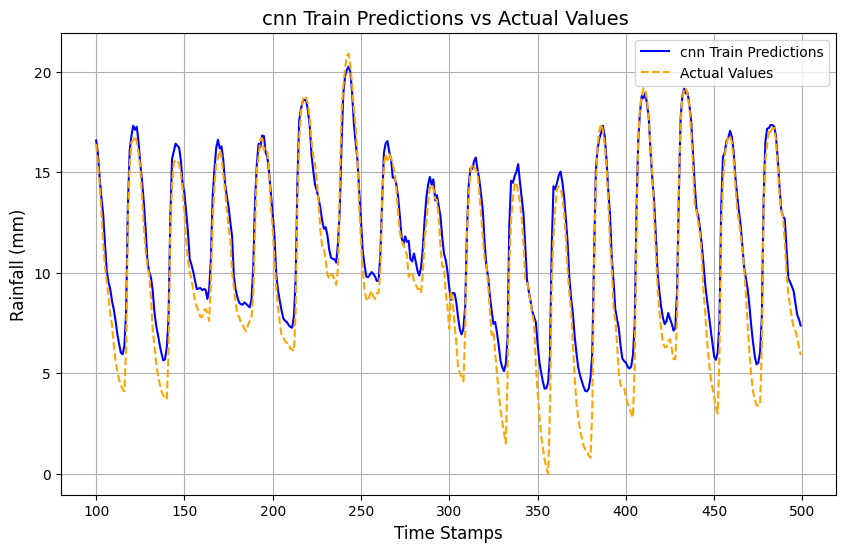

685/685 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
       cnn Val Predictions  Actual Values
0                17.163940           16.5
1                15.599930           15.2
2                13.886675           15.1
3                14.450436           11.1
4                11.704327           10.9
...                    ...            ...
21913            29.599339           29.1
21914            28.423370           29.6
21915            28.643745           29.0
21916            28.048569           27.0
21917            26.460796           26.4

[21918 rows x 2 columns]


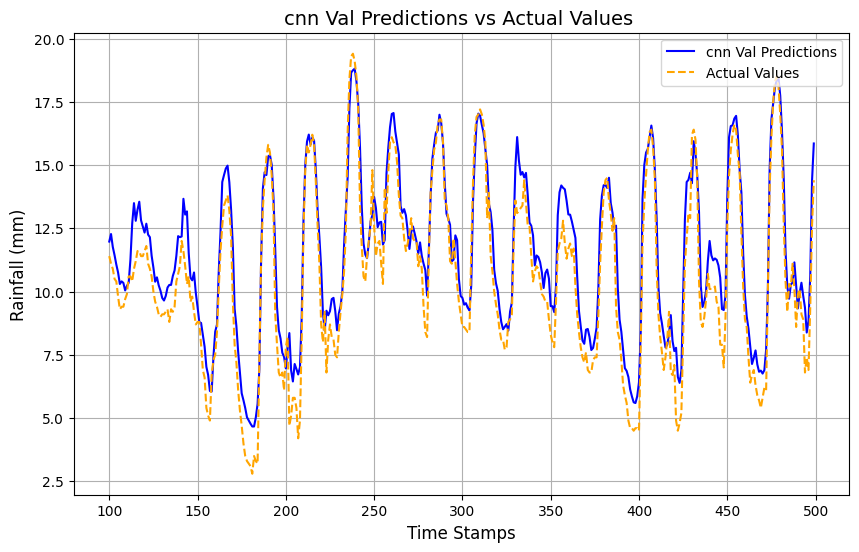

685/685 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
       cnn Test Predictions  Actual Values
0                 25.608341           25.6
1                 25.224194           25.6
2                 25.169802           25.4
3                 24.839020           25.3
4                 24.646706           24.6
...                     ...            ...
21915              8.577825            9.8
21916              9.429409           10.6
21917             10.559887           11.1
21918             11.123485           10.5
21919             10.858702            9.1

[21920 rows x 2 columns]


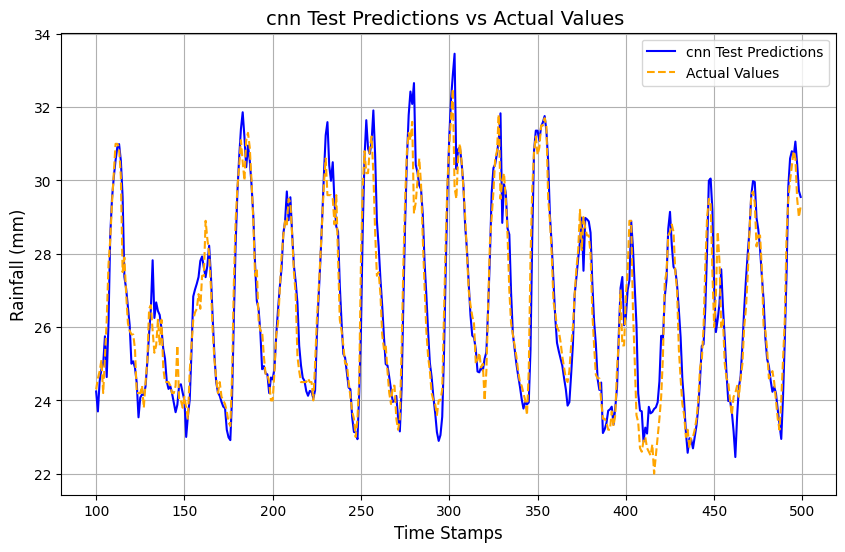


Training LSTM model with WEIGHTED_MSE loss...
Epoch 1/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 101s 17ms/step - loss: 81.5517 - mae: 4.9506 - mse: 47.5715 - root_mean_squared_error: 6.5186 - val_loss: 3.0532 - val_mae: 1.2457 - val_mse: 2.4490 - val_root_mean_squared_error: 1.5649 - learning_rate: 0.0010
Epoch 2/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 72s 13ms/step - loss: 14.9070 - mae: 2.5155 - mse: 10.5920 - root_mean_squared_error: 3.2527 - val_loss: 2.5523 - val_mae: 0.9865 - val_mse: 1.6273 - val_root_mean_squared_error: 1.2757 - learning_rate: 0.0010
Epoch 3/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 73s 13ms/step - loss: 10.0155 - mae: 2.0445 - mse: 7.1094 - root_mean_squared_error: 2.6660 - val_loss: 1.7333 - val_mae: 0.7553 - val_mse: 0.9988 - val_root_mean_squared_error: 0.9994 - learning_rate: 0.0010
Epoch 4/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 72s 13ms/step - loss: 7.7367 - mae: 1.7816 - mse: 5.4762 - root_mean_squared_error: 2.3399 - val_loss: 1.6560 - val_mae: 0.7188 - val_mse: 0.9356 - val_root_me

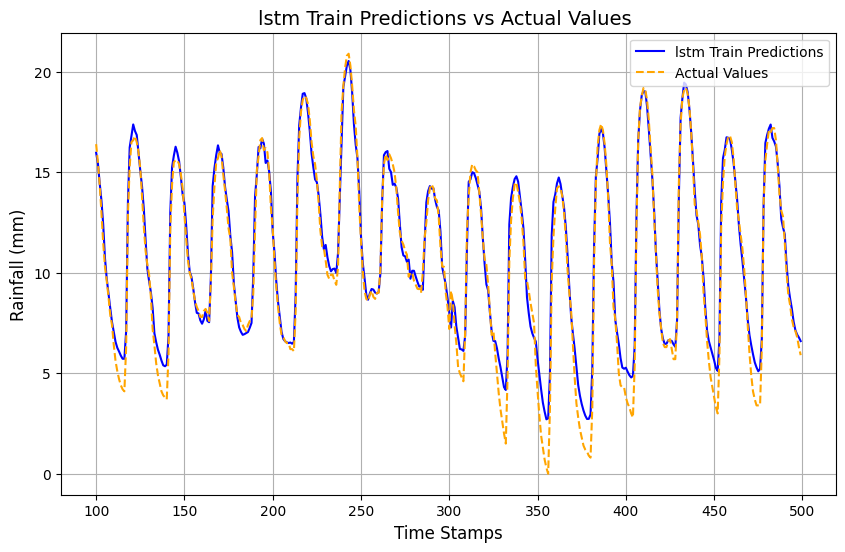

685/685 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
       lstm Val Predictions  Actual Values
0                 16.847076           16.5
1                 15.332466           15.2
2                 13.778568           15.1
3                 14.182255           11.1
4                 10.717584           10.9
...                     ...            ...
21913             28.917299           29.1
21914             28.133297           29.6
21915             28.464144           29.0
21916             27.552998           27.0
21917             25.823404           26.4

[21918 rows x 2 columns]


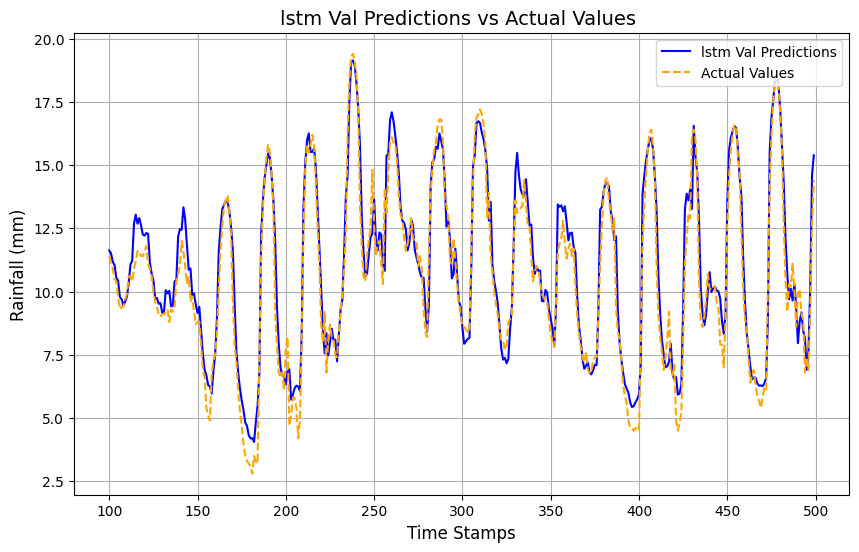

685/685 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
       lstm Test Predictions  Actual Values
0                  25.416063           25.6
1                  24.928179           25.6
2                  25.037527           25.4
3                  24.515959           25.3
4                  24.711168           24.6
...                      ...            ...
21915               7.098482            9.8
21916               7.858022           10.6
21917               9.188463           11.1
21918               9.984472           10.5
21919               9.736380            9.1

[21920 rows x 2 columns]


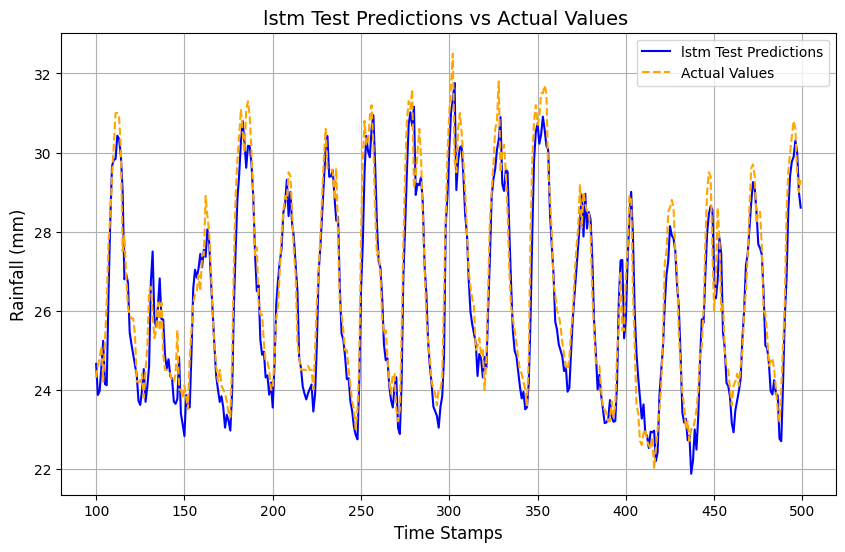


Training GRU model with WEIGHTED_MSE loss...
Epoch 1/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 57s 10ms/step - loss: 75.7614 - mae: 4.8720 - mse: 44.9370 - root_mean_squared_error: 6.3743 - val_loss: 3.8625 - val_mae: 1.3174 - val_mse: 2.9336 - val_root_mean_squared_error: 1.7128 - learning_rate: 0.0010
Epoch 2/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 52s 10ms/step - loss: 15.0311 - mae: 2.5325 - mse: 10.7471 - root_mean_squared_error: 3.2747 - val_loss: 1.7843 - val_mae: 0.8134 - val_mse: 1.2341 - val_root_mean_squared_error: 1.1109 - learning_rate: 0.0010
Epoch 3/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 73s 13ms/step - loss: 10.1305 - mae: 2.0711 - mse: 7.2795 - root_mean_squared_error: 2.6973 - val_loss: 1.7601 - val_mae: 0.8212 - val_mse: 1.2339 - val_root_mean_squared_error: 1.1108 - learning_rate: 0.0010
Epoch 4/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 71s 13ms/step - loss: 7.8393 - mae: 1.8288 - mse: 5.6809 - root_mean_squared_error: 2.3832 - val_loss: 1.7070 - val_mae: 0.8094 - val_mse: 1.2067 - val_root_mean

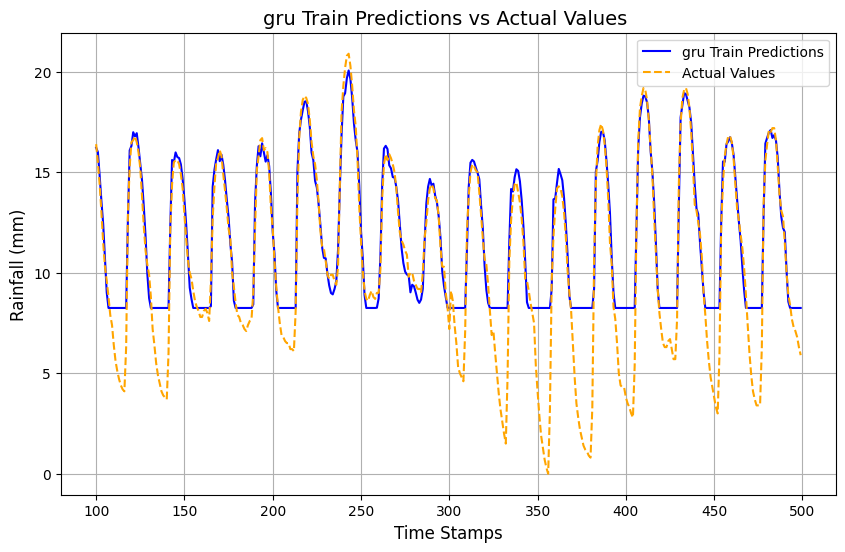

685/685 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
       gru Val Predictions  Actual Values
0                17.262823           16.5
1                15.717220           15.2
2                14.282770           15.1
3                14.838787           11.1
4                10.702083           10.9
...                    ...            ...
21913            29.521709           29.1
21914            28.738331           29.6
21915            28.548805           29.0
21916            27.976772           27.0
21917            26.412365           26.4

[21918 rows x 2 columns]


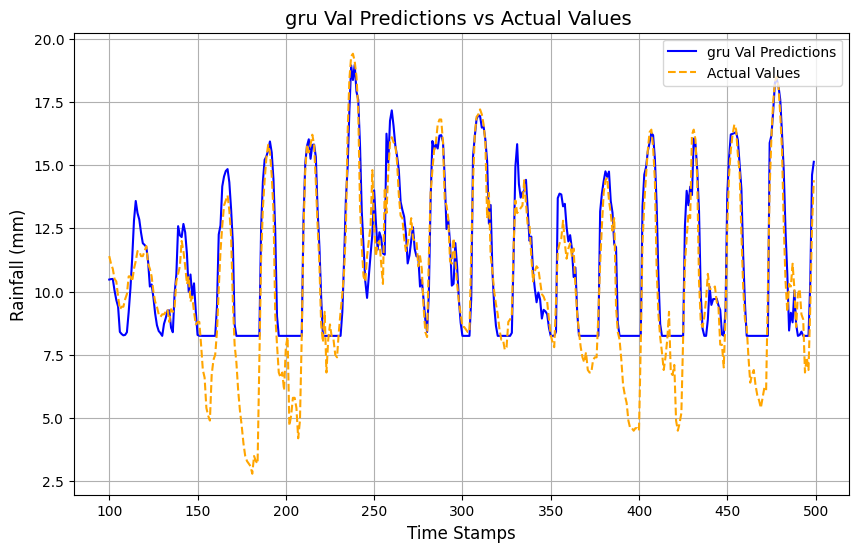

685/685 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
       gru Test Predictions  Actual Values
0                 25.524437           25.6
1                 24.895672           25.6
2                 25.130684           25.4
3                 24.698956           25.3
4                 24.630825           24.6
...                     ...            ...
21915              8.248401            9.8
21916              8.248401           10.6
21917              8.701614           11.1
21918              9.955041           10.5
21919              9.438866            9.1

[21920 rows x 2 columns]


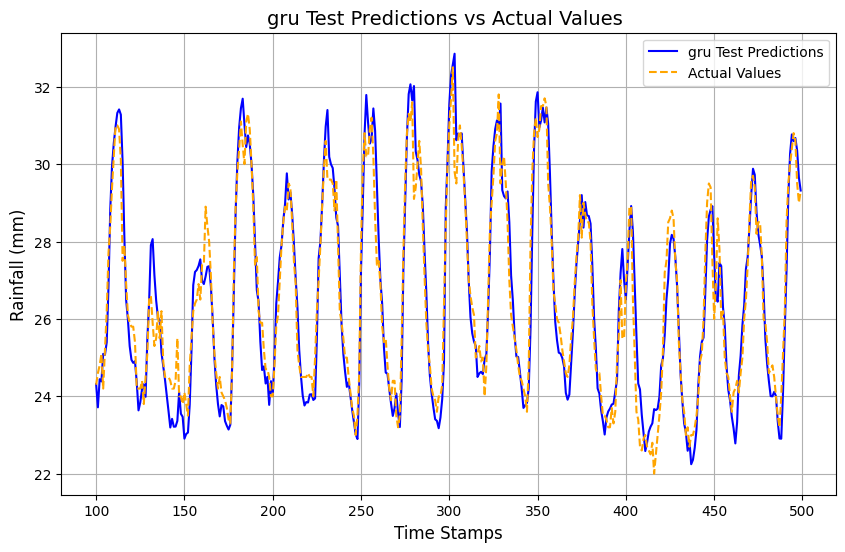

Results for loss function 'weighted_mse' saved in '../artifacts/results/test_6/weighted_mse'.

Training CNN model with CUSTOM loss...
Epoch 1/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 37s 6ms/step - loss: 67.3834 - mae: 4.6019 - mse: 38.8317 - root_mean_squared_error: 5.9826 - val_loss: 2.8323 - val_mae: 1.0061 - val_mse: 1.6913 - val_root_mean_squared_error: 1.3005 - learning_rate: 0.0010
Epoch 2/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 44s 8ms/step - loss: 18.0444 - mae: 2.6233 - mse: 11.6405 - root_mean_squared_error: 3.4107 - val_loss: 2.3066 - val_mae: 0.9050 - val_mse: 1.5040 - val_root_mean_squared_error: 1.2264 - learning_rate: 0.0010
Epoch 3/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 64s 12ms/step - loss: 13.3533 - mae: 2.2421 - mse: 8.6445 - root_mean_squared_error: 2.9394 - val_loss: 3.0069 - val_mae: 1.0391 - val_mse: 1.6588 - val_root_mean_squared_error: 1.2879 - learning_rate: 0.0010
Epoch 4/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 62s 11ms/step - loss: 10.3741 - mae: 1.9648 - mse: 6.7072 - root_mean_squar

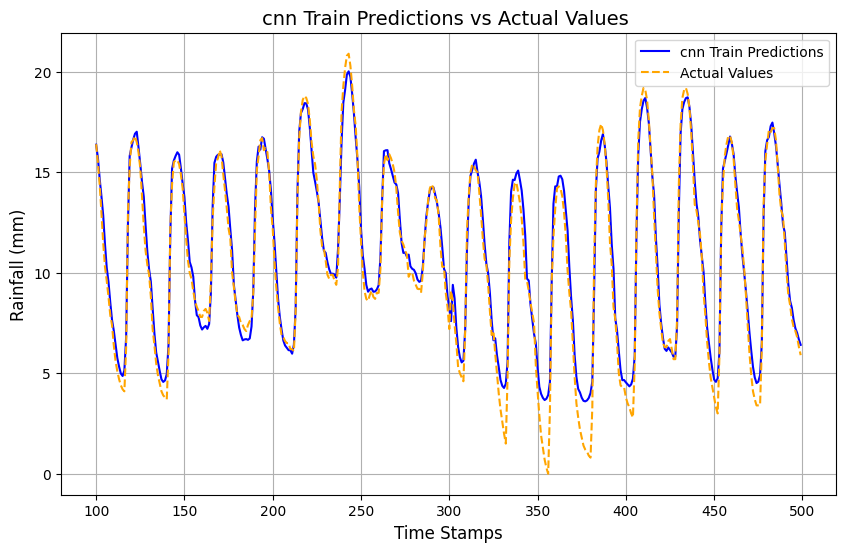

685/685 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
       cnn Val Predictions  Actual Values
0                17.249273           16.5
1                15.692234           15.2
2                14.257191           15.1
3                14.201640           11.1
4                11.382496           10.9
...                    ...            ...
21913            28.404593           29.1
21914            27.663702           29.6
21915            27.992952           29.0
21916            27.759741           27.0
21917            26.283115           26.4

[21918 rows x 2 columns]


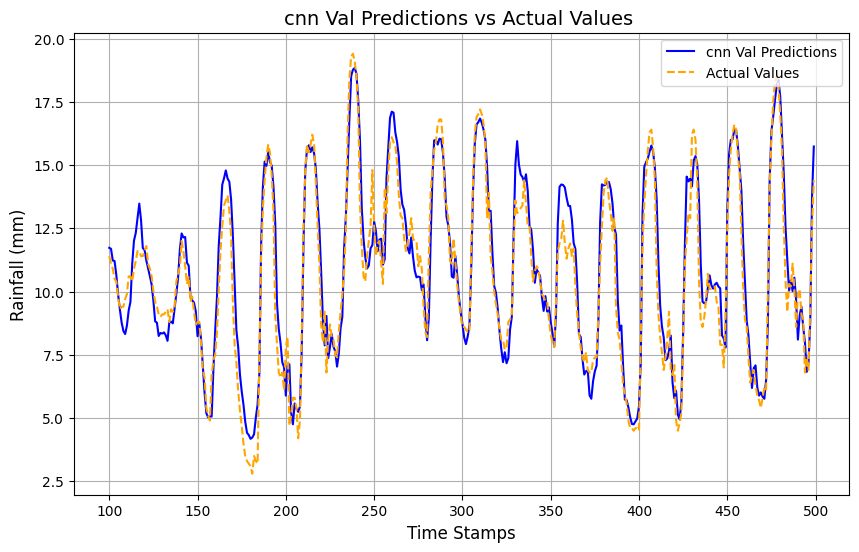

685/685 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
       cnn Test Predictions  Actual Values
0                 25.648540           25.6
1                 25.193668           25.6
2                 25.066212           25.4
3                 24.924856           25.3
4                 24.604094           24.6
...                     ...            ...
21915              8.120988            9.8
21916              8.901215           10.6
21917              9.748167           11.1
21918             10.103130           10.5
21919              9.828586            9.1

[21920 rows x 2 columns]


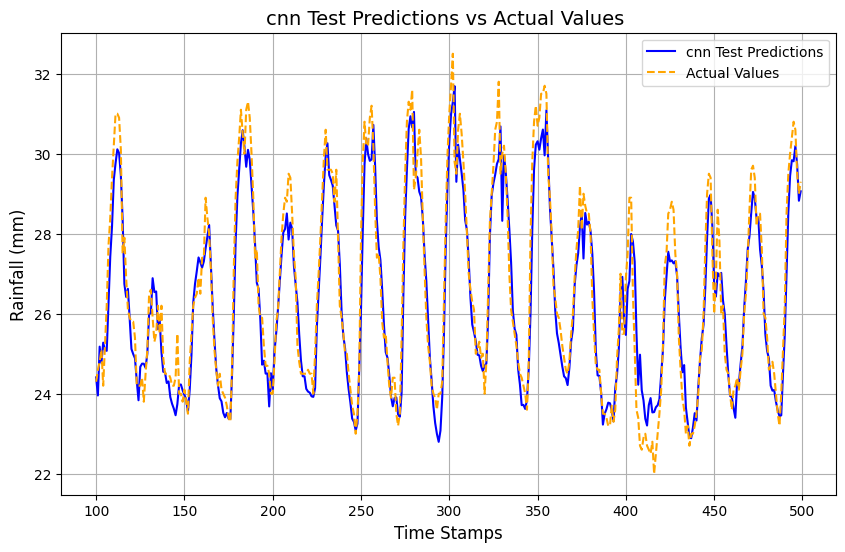


Training LSTM model with CUSTOM loss...
Epoch 1/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 66s 11ms/step - loss: 89.5536 - mae: 5.0364 - mse: 49.7705 - root_mean_squared_error: 6.6391 - val_loss: 3.4220 - val_mae: 1.0618 - val_mse: 2.1481 - val_root_mean_squared_error: 1.4656 - learning_rate: 0.0010
Epoch 2/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 74s 13ms/step - loss: 16.2213 - mae: 2.4886 - mse: 10.3931 - root_mean_squared_error: 3.2222 - val_loss: 2.4127 - val_mae: 0.9659 - val_mse: 1.4620 - val_root_mean_squared_error: 1.2091 - learning_rate: 0.0010
Epoch 3/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 72s 13ms/step - loss: 11.1822 - mae: 2.0472 - mse: 7.1815 - root_mean_squared_error: 2.6791 - val_loss: 1.6525 - val_mae: 0.7260 - val_mse: 0.9701 - val_root_mean_squared_error: 0.9849 - learning_rate: 0.0010
Epoch 4/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 69s 13ms/step - loss: 8.4478 - mae: 1.7687 - mse: 5.3876 - root_mean_squared_error: 2.3208 - val_loss: 1.9830 - val_mae: 0.7984 - val_mse: 1.1289 - val_root_mean_squa

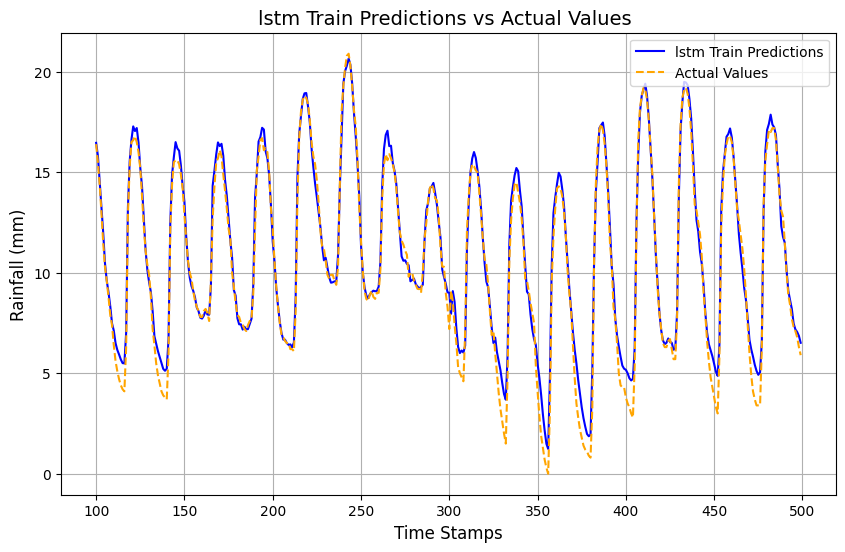

685/685 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step
       lstm Val Predictions  Actual Values
0                 17.422710           16.5
1                 15.924356           15.2
2                 13.877598           15.1
3                 13.811975           11.1
4                 10.324174           10.9
...                     ...            ...
21913             29.039791           29.1
21914             28.033138           29.6
21915             27.910961           29.0
21916             27.184170           27.0
21917             25.539246           26.4

[21918 rows x 2 columns]


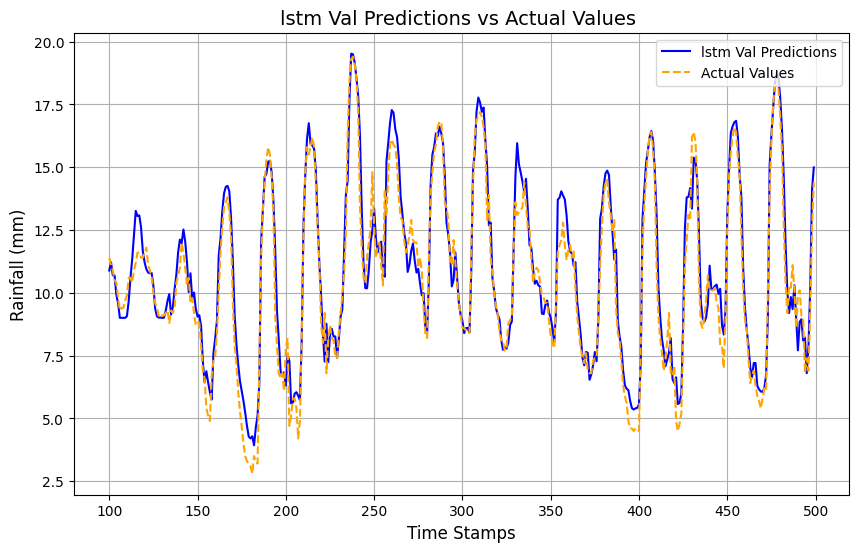

685/685 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
       lstm Test Predictions  Actual Values
0                  24.873257           25.6
1                  24.480171           25.6
2                  24.662804           25.4
3                  24.244652           25.3
4                  24.379728           24.6
...                      ...            ...
21915               8.011600            9.8
21916               8.557625           10.6
21917               9.343217           11.1
21918              10.108276           10.5
21919               9.628796            9.1

[21920 rows x 2 columns]


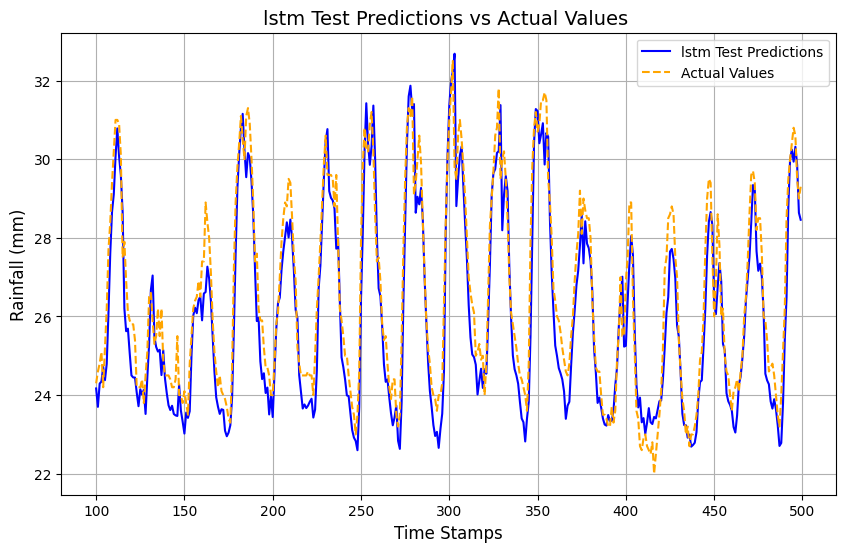


Training GRU model with CUSTOM loss...
Epoch 1/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 62s 11ms/step - loss: 82.9553 - mae: 4.9114 - mse: 46.3737 - root_mean_squared_error: 6.4239 - val_loss: 3.4273 - val_mae: 1.1253 - val_mse: 2.2071 - val_root_mean_squared_error: 1.4856 - learning_rate: 0.0010
Epoch 2/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 58s 11ms/step - loss: 14.9240 - mae: 2.3947 - mse: 9.5927 - root_mean_squared_error: 3.0952 - val_loss: 2.2307 - val_mae: 0.8901 - val_mse: 1.2964 - val_root_mean_squared_error: 1.1386 - learning_rate: 0.0010
Epoch 3/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 57s 10ms/step - loss: 10.1767 - mae: 1.9669 - mse: 6.6068 - root_mean_squared_error: 2.5697 - val_loss: 2.4638 - val_mae: 0.9546 - val_mse: 1.3792 - val_root_mean_squared_error: 1.1744 - learning_rate: 0.0010
Epoch 4/5
5480/5480 ━━━━━━━━━━━━━━━━━━━━ 57s 10ms/step - loss: 8.0687 - mae: 1.7566 - mse: 5.2628 - root_mean_squared_error: 2.2939 - val_loss: 2.9697 - val_mae: 1.0226 - val_mse: 1.6214 - val_root_mean_square

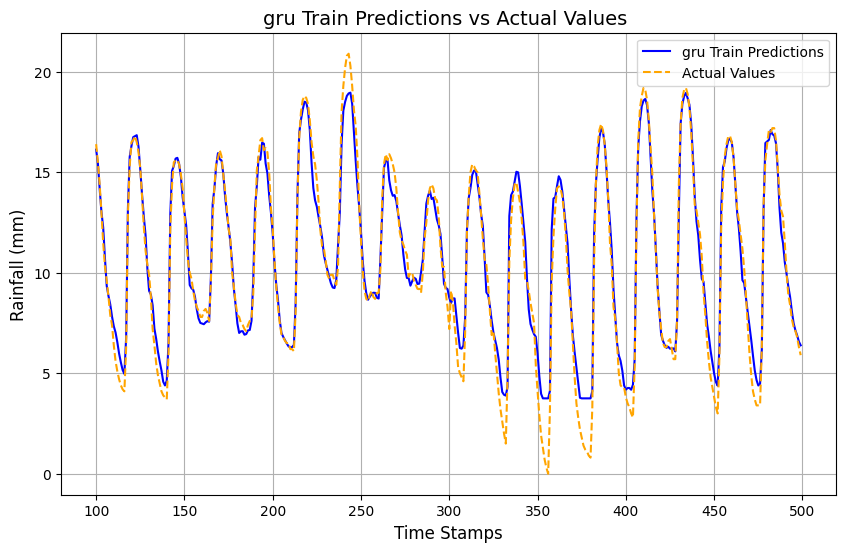

685/685 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
       gru Val Predictions  Actual Values
0                17.103458           16.5
1                15.391777           15.2
2                13.505737           15.1
3                13.208601           11.1
4                11.573174           10.9
...                    ...            ...
21913            28.438313           29.1
21914            27.908924           29.6
21915            27.614843           29.0
21916            26.747259           27.0
21917            25.844387           26.4

[21918 rows x 2 columns]


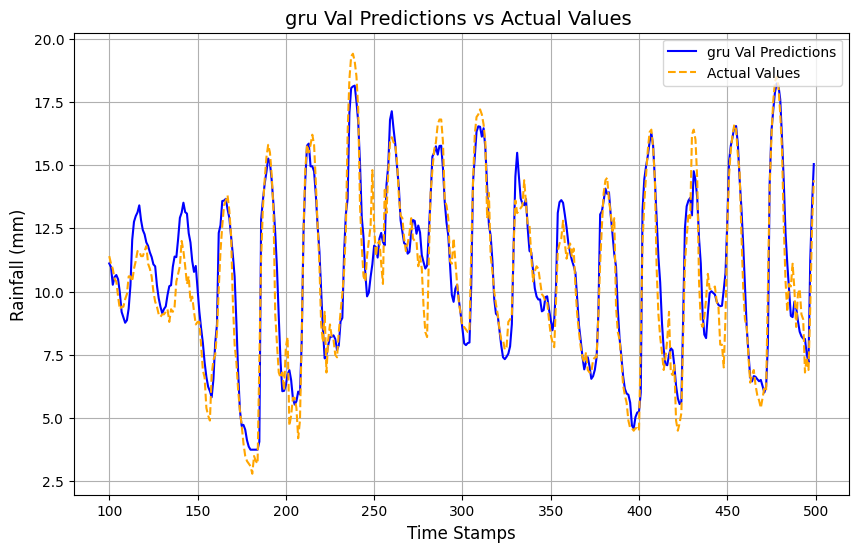

685/685 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
       gru Test Predictions  Actual Values
0                 25.518879           25.6
1                 24.988827           25.6
2                 24.828564           25.4
3                 24.487820           25.3
4                 24.422607           24.6
...                     ...            ...
21915              6.725981            9.8
21916              6.446866           10.6
21917              7.162553           11.1
21918              8.248333           10.5
21919              9.026617            9.1

[21920 rows x 2 columns]


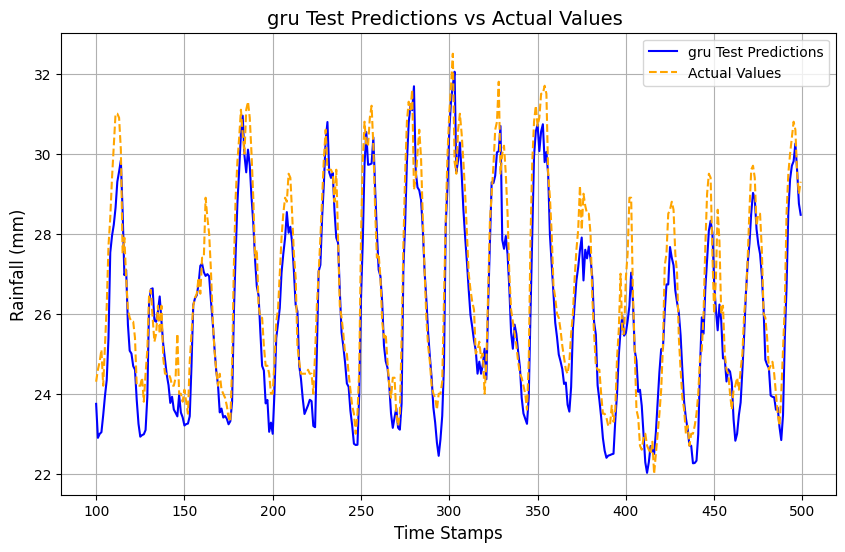

Results for loss function 'custom' saved in '../artifacts/results/test_6/custom'.

Model Evaluation Results:

CNN:
mse: 1.0853
mae: 0.7914
false_negative_rate: 0.0000

LSTM:
mse: 0.9250
mae: 0.7197
false_negative_rate: 0.0000

GRU:
mse: 1.4531
mae: 0.9429
false_negative_rate: 0.0000


In [15]:
# Main execution
def main():
    try:
        # Define loss functions to iterate over
        loss_functions = ['weighted_mse', 'custom']
        
        for loss_function in loss_functions:
            # Create a directory for the current loss function
            results_dir = f'../artifacts/results/test_6/{loss_function}'
            os.makedirs(results_dir, exist_ok=True)
        
            # Train models
            models = {
                'cnn': create_cnn_model(input_shape=(X_train.shape[1], X_train.shape[2])),
                'lstm': create_lstm_model(input_shape=(X_train.shape[1], X_train.shape[2])),
                'gru': create_gru_model(input_shape=(X_train.shape[1], X_train.shape[2])),
            }
            
            results = {}
            for name, model in models.items():
                print(f"\nTraining {name.upper()} model with {loss_function.upper()} loss...")
                
                try:
                    history = train_model(
                        model, X_train, y_train, X_val, y_val,
                        f'../artifacts/models/test_6/model_{name}_{loss_function}.keras', 
                        epochs=5, loss_function=loss_function, learning_rate=1e-3
                    )
                except Exception as e:
                    print(f"Error training {name.upper()} model: {e}")
                    continue
                
                try:
                    
                    
                    results[name] = evaluate_model(model, X_test, y_test)
                except Exception as e:
                    print(f"Error evaluating {name.upper()} model: {e}")
                    continue
                
                # Save training history to CSV
                history_df = pd.DataFrame(history.history)
                history_df.to_csv(os.path.join(results_dir, f'{name}_history.csv'), index=False)
                
                # Plot training history
                plt.figure(figsize=(10, 6))
                plt.plot(history.history['loss'], label='Training Loss')
                plt.plot(history.history['val_loss'], label='Validation Loss')
                plt.title(f'{name.upper()} Model Training History')
                plt.xlabel('Epoch')
                plt.ylabel('Loss')
                plt.legend()
                plt.savefig(os.path.join(results_dir, f'{name}_training_history.png'))
                plt.close()  # Close the plot to free memory
                
                # Save evaluation results to a text file
                with open(os.path.join(results_dir, f'{name}_evaluation.txt'), 'w') as f:
                    for metric_name, value in results[name].items():
                        f.write(f"{metric_name}: {value:.4f}\n")
                
                # Plot predictions for Train, Val, and Test datasets and save the plots
                    for dataset, data, true_values in zip(['Train', 'Val', 'Test'], 
                                                        [X_train, X_val, X_test], 
                                                        [y_train, y_val, y_test]):
                        plot_predictions(
                            model=model, 
                            X_data=data, 
                            y_data=true_values, 
                            label=name + ' ' + dataset, 
                            start=100, 
                            end=500
                        )
                        # plt.savefig(os.path.join(results_dir, f'{name}_{dataset.lower()}_predictions.png'))
                        plt.close()  # Close the plot to free memory
            
            print(f"Results for loss function '{loss_function}' saved in '{results_dir}'.")
        
        return results
    except Exception as e:
        print(f"Error in main: {e}")
        raise

if __name__ == "__main__":
    try:
        results = main()
        print("\nModel Evaluation Results:")
        for model_name, metrics in results.items():
            print(f"\n{model_name.upper()}:")
            for metric_name, value in metrics.items():
                print(f"{metric_name}: {value:.4f}")
    except Exception as e:
        print(f"Unhandled error in execution: {e}")

Q. Workflow didn't irerate for other loss functions, only trained for the custom loss function, why is that??

A. The issue in your main function arises from the placement of the model training and evaluation code inside the loop that iterates over the loss functions. Specifically, the code for training the models and saving results is not nested within the loop that iterates over the loss_functions. As a result, it only executes for the last loss function defined in the loop.

# Metrics Interpretation

1. **Mean Squared Error (MSE):** Lower values indicate better performance, as MSE measures the average squared difference between predicted and actual values.
2. **Mean Absolute Error (MAE):** Similar to MSE, lower values are better. MAE measures the average absolute difference between predicted and actual values.
3. **False Negative Rate (FNR):** A lower false negative rate is better, as it indicates that the model is correctly identifying positive cases. A high FNR means the model is missing many positive cases.

# Model Evaluation Results:

1. **LSTM:** 
* *mse:* 0.5540 
* *mae:* 0.1721 
* *false_negative_rate:* 0.5877

2. **GRU:** 
* *mse:* 0.4852 
* *mae:* 0.1671 
* *false_negative_rate:* 0.4767

3. **CNN:** 
* *mse:* 0.4841 
* *mae:* 0.1733 
* *false_negative_rate:* 0.5009

4. **CNN_2:** 
* *mse:* 1.1112 
* *mae:* 0.8054 
* *false_negative_rate:* 0.0000

### Conclusion *(Based on the evaluation metrics)*:

* **Best Overall Model:** GRU seems to be the best choice overall, as it has the lowest MAE and a competitive FNR.
* **Best for MSE:** CNN has the lowest MSE, but its FNR is higher than that of the GRU.
* **Best for False Negatives:** CNN_2 has a perfect FNR, but its overall prediction quality is poor.

### Recommendation
If your primary concern is minimizing average prediction error, the GRU is the best choice. If you are particularly concerned about false negatives (e.g., in a medical diagnosis context), you might want to investigate the CNN_2 further, despite its poor overall performance.